# ECE-6524 / CS-6524 Deep Learning
# Assignment 1 [90 pts]

In this assignment, **you need to complete the following three sectoins**:
1. SVM Classifier
    - Calculating loss and gradient
2. Linear Classfier with Softmax 
    - Calculating loss and gradient
3. Simple Neural Network with Multilayer Perceptrons
    - Read the forward and backward propogation
    - Experiment with simple NN

This assignment is inspired and adopted from Stanford CS231n, UIUC Deep Learning course and Deep Learning Lab from Professor Vicente Ordonez at the University of Virginia.
## Submission guideline

1. Click the Save button at the top of the Jupyter Notebook.
2. Please make sure to have entered your Virginia Tech PID below.
3. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of ll cells).
4. Select Cell -> Run All. This will run all the cells in order.
5. Once you've rerun everything, select File -> Download as -> PDF via LaTeX
6. Look at the PDF file and make sure all your solutions are there, displayed correctly. 
7. Zip BOTH the PDF file and this notebook. Rem
8. Submit your zipped file.

**While you are encouraged to discuss with your peers, <span style="color:blue">all work submitted is expected to be your own.</span> <span style="color:red">If you use any information from other resources (e.g. online materials), you are required to cite it below you VT PID. Any violation will result in a 0 mark for the assignment.</span>**

### Please Write Your VT PID Here: 906255893
### Reference (if any):
https://stackoverflow.com/questions/13717554/weird-behaviour-initializing-a-numpy-array-of-string-data

https://mlxai.github.io/2017/01/06/vectorized-implementation-of-svm-loss-and-gradient-update.html

https://zhuanlan.zhihu.com/p/30965514 # Used code here to check against my code

https://stackoverflow.com/questions/30917753/subsetting-a-2d-numpy-array

https://medium.com/datadriveninvestor/k-fold-cross-validation-for-parameter-tuning-75b6cb3214f # To better understand SVM gradient

https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/ # to understand the "logits" argument of the softmax function

https://stackoverflow.com/questions/41663874/cs231n-how-to-calculate-gradient-for-softmax-loss-function # Used second answer to better understand softmax gradient

https://pydatascience.org/2017/11/24/plot-multiple-lines-in-one-chart-with-different-style-python-matplotlib/

In this homework, you would need to use **Python 3.6+** along with the following packages:
```
1. numpy
2. matplotlib
3. scipy
```
All packages above can be installed through `pip install`.

In addition, you will need to have [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset in your `cifar10/cifar-10-batches-py` folder. We provide a bash script `cifar10/get_dataset.sh` to help you download and unpack the dataset.

Once you are done with the things above, you can proceed to execute the following cells:

In [1]:
import random
import numpy as np
from data_process import get_CIFAR10_data
import math
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Loading CIFAR-10

In the following cells, we would first load the CIFAR10 dataset, and prepare them for our classifier:

In [2]:
# You can change these numbers for experimentation
# For submission we will use the default values 
TRAIN_IMAGES = 49000
VAL_IMAGES = 1000
TEST_IMAGES = 1000

In [3]:
data = get_CIFAR10_data(TRAIN_IMAGES, VAL_IMAGES, TEST_IMAGES, subtract_mean=False)
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']
X_test, y_test = data['X_test'], data['y_test']

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(49000, 32, 32, 3)
(49000,)
(1000, 32, 32, 3)
(1000,)
(1000, 32, 32, 3)
(1000,)


Now, we visualize the dataset to get a better idea of it.

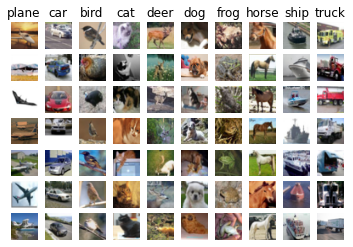

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

We then subtract all the images with the **mean image** of the training set. This trick is commonly used in Computer Vision community, as it arranges the features into a range that is more manageable for the models.

In [6]:
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

Now, we convert the sets of images from dimensions of **(N, 3, 32, 32) -> (N, 3072)** where N is the number of images so that each **3x32x32** image is represented by a single vector. This allows us to feed the data into our classifiers.

In [7]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

In [8]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(49000, 3072)
(1000, 3072)
(1000, 3072)


Here, we concatenate all the features with ones. This trick is particularly convenient, as in this case, we only need to deal with a single weight matrix $W$ instead of both $W$ and bias $b$ in our training code.

In [9]:
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

In [10]:
# you should get the following output:
# (49000, 3073)
# (1000, 3073)
# (1000, 3073)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(49000, 3073)
(1000, 3073)
(1000, 3073)


### Calculate Classification Accuracy

Here is a simple helper function for calculation of the classification accuracy:

In [11]:
def get_acc(pred, y_test):
    return np.sum(y_test==pred)/len(y_test)*100

In [12]:
# test get_acc
print(get_acc(y_train, y_train))

100.0


# Section 1. Support Vector Machines (with SGD) [30 pts]

In this section, you will need to implement a **soft margin SVM** for a **multi-class classification problem**. In the soft margin SVM, you will maximize the margin between positive and negative training examples and penalize margin violations using a hinge loss.

We will optimize the SVM loss using SGD. This means you must compute the loss function with respect to model weights. You will use this gradient to update the model weights.

SVM optimized with SGD has 3 hyperparameters that you can experiment with :
- `lr` - the learning rate of your model. This parameter scales by how much the weights are changed according to the calculated gradient update
- `n_iter` - the number of training batches you are gonna use for updating your model.
- `reg_const` - Hyperparameter to determine the strength of regularization. In this case it is a coefficient on the term which maximizes the margin.

## 1.1. Implementing SVM with SGD [25 pts]

Recall that the multiclass SVM loss can be written as:
\begin{align}
\begin{gathered}
s=f(x_i, W) \\
L_i = \sum_{j\neq y_i} \left[ \max(0, s_j - s_{y_i} + margin) \right]
\end{gathered}
\end{align}
where $s={s_j}$ is the vector of prediction scores of all class, $s_j$ is the prediction score for class $j$, and $y_i$ is the groud truth class label. The margin is usually set to 1. Now, to learn the weights $W$, we can differentiate the function $L_i$ to get the gradient:
\begin{equation}
\begin{gathered}
\nabla_{w_{y_i}} L_i = - \left( \sum_{j\neq y_i} \mathbb{1}(w_j^Tx_i - w_{y_i}^Tx_i + 1 > 0) \right) x_i\\
\end{gathered}
\end{equation}
where $\mathbb{1}$ is the indicator function that is one if the condition inside is true or zero otherwise, and $w_j$ represents the row $j$ in your weight matrix $W$. To implement this, you’d simply count the number of classes that didn’t meet the desired margin 1 (and hence contributed to the loss function) and then the data vector $x_i$ scaled by this number is the gradient. Note that, in the equation above, we are only calculating the gradient with respect to the row of $W$ that corresponds to the correct class $y_i$. For the other rows $j\neq y_i$, we have:
\begin{equation}
\nabla_{w_j} L_i = \mathbb{1}(w_j^Tx_i - w_{y_i}^Tx_i + 1 > 0) x_i
\end{equation}
Now, we have derived the gradient expression above, it is time to turn these equations into the actual running code.
We provide a template for implementing your SVM classfier below. You have to fill in the **TODO** part, and train your classifier.

In [13]:

class SVM():
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.w = np.random.randn(input_size, output_size) * 0.001
        
    def calc_grad_and_loss(self, X_train, y_train, reg, margin):
        """
          Calculate gradient of the svm hinge loss.
          
          Inputs have dimension D, there are C classes, and we operate on minibatches
          of N examples.

          Inputs:
          - X_train: A numpy array of shape (N, D) containing a minibatch of data.
          - y_train: A numpy array of shape (N,) containing training labels; y[i] = c means
            that X[i] has label c, where 0 <= c < C.
          - reg: A float number Regularization strength;
          - margin: A float number margin for the multi-class SVM loss (usually set to 1);

          Returns:
          - gradient with respect to weights w; an array of same shape as w;
          - multi-class SVM loss;
        """
        ################################################################################
        # TODO:                                                                        #
        # Calculate the loss and gradient for the SVM classifier.                      #
        ################################################################################
        self.training_X = X_train
        self.training_y = y_train
        self.reg = reg
        self.margin = margin

        #W = np.random.randn(num_classes, (int(training_X.shape[1]-1))) * 0.001  #code I used to manually build W matrix for testing
        #b = np.array([[1.1,3.2,-1.2,1.1,3.2,-1.2,1.1,3.2,-1.2,1.1]]             #code I used to manually set bias
        #b = np.transpose(b)                                                     #transposing bias into a column vector 
        #W = np.append(W,b,1)                                                    #including bias into weight matrix 
        W = self.w                                                               #renaming the weight matrix because I started out callling it W and didn't want to rewrite code
        Xprime = self.training_X.T                                               #I'm following the notation uused in the lecture so I had to transpose data to get score column vectors not row vectors
        scores = W.dot(Xprime)                                                   #Computing scores for all images at once using matrix multiplication
        scrdiff_mat = np.ones((scores.shape))                                    #Creating a matrix of ones 
        for i in range(self.training_y.shape[0]):
            scrdiff_mat[:,i] = scrdiff_mat[:,i]*scores[self.training_y[i],i]     #Filling the columns with the true score for each image
        scrdiff_mat = scores - scrdiff_mat + margin                              #Computing the loss (s_j - s_i + margin)
        scrdiff_mat = scrdiff_mat*(scrdiff_mat>0)                                #Replacing negative results from previous line with zeros (equivalent to max operation)
        J_mat = np.ones((num_classes,self.training_y.shape[0]))                  #Creating a matrix of ones
        for i in range(self.training_y.shape[0]):
            J_mat[self.training_y[i],i] = 0                                      #Replacing the position of true labels with zeros
        loss_by_image = np.zeros(self.training_y.shape[0])                       #Creating a vector to hold L_i, individual image loss
        for i in range(self.training_y.shape[0]):       
            loss_by_image[i] = np.dot(J_mat.T[i,:],scrdiff_mat[:,i])             #using matrix multiplication to compute individual image loss
        
        loss_by_class = np.zeros(W.shape[0])                                     #Creating a vector to hold loss by class
        for i in range(W.shape[0]):
            loss_by_class[i] = sum(loss_by_image*(self.training_y==i))           #Computing loss by class as sum of image loss for all images that match class labels
        overall_loss = sum(loss_by_image)/self.training_y.shape[0]               #Computing multiclass SVM loss as average of individual image loss
        loss = overall_loss                                                      #Renaming loss to match following portions of code

        #Full analytical gradient
        W_grad = np.zeros((W.shape[0],W.shape[1]))                               #Creating matrix of zeros to hold gradient
        for i in range(self.training_X.shape[0]):
            addtl_grad = np.zeros((W.shape[0],W.shape[1]))                       #Creating matrix of zeros to hold gradient for each individual image
            for j in range(W.shape[0]):
                if j==self.training_y[i]:                                        #If statement to reflect different gradient value at true label
                    addtl_grad[j] = (-sum(np.multiply(J_mat[:,i],scrdiff_mat[:,i])>0)*self.training_X[i,:])     #Gradient value at true label
                else:
                    addtl_grad[j] = (scrdiff_mat[:,i]>0)[j]*self.training_X[i,:]    #Gradient value at false label
            W_grad += addtl_grad                                                 #Adding up gradients from each image to obtain overall gradient
        W_grad = W_grad/(self.training_X.shape[0])                               #Dividing by number of images to obtain "Average gradient" 
        del J_mat                                                                #Deleting items to free up memory
        #Full gradient with regularization
        grad_w = W_grad+2*reg*W                                                  #Adjusting gradient for regularization factor
        self.grad = grad_w                                                       #Adding ability to directly call gradient for checking

        #######################################################################
        ## Code to check Analytical gradient using numeric gradient          ##
        #######################################################################
        #Numerical Gradient
        #import copy
        #h = 0.00000001
        #grad_w_num = np.zeros((W.shape[0],W.shape[1]))                               #Creating matrix of zeros to hold gradient
        #W1 = copy.copy(W)
        #L1 = loss                                                     
        #for k in range(W.shape[0]):
        #    for j in range(W.shape[1]):
        #        W2 = copy.copy(W1)
        #        W2[k,j] += h
        #        scores2 = W2.dot(Xprime)                                                 #Computing scores for all images at once using matrix multiplication
        #        scrdiff_mat2 = np.ones((scores2.shape))                                   #Creating a matrix of ones 
        #        for i in range(self.training_y.shape[0]):
        #            scrdiff_mat2[:,i] = scrdiff_mat2[:,i]*scores2[self.training_y[i],i]  #Filling the columns with the true score for each image
        #        scrdiff_mat2 = scores2 - scrdiff_mat2 + margin                              #Computing the loss (s_j - s_i + margin)
        #        scrdiff_mat2 = scrdiff_mat2*(scrdiff_mat2>0)                                #Replacing negative results from previous line with zeros (equivalent to max operation)
        #        J_mat2 = np.ones((num_classes,self.training_y.shape[0]))                  #Creating a matrix of ones
        #        for i in range(self.training_y.shape[0]):
        #            J_mat2[self.training_y[i],i] = 0                                      #Replacing the position of true labels with zeros
        #        loss_by_image2 = np.zeros(self.training_y.shape[0])                       #Creating a vector to hold L_i, individual image loss
        #        for i in range(self.training_y.shape[0]):       
        #            loss_by_image2[i] = np.dot(J_mat2.T[i,:],scrdiff_mat2[:,i])             #using matrix multiplication to compute individual image loss
        #        L2 = sum(loss_by_image2)/self.training_y.shape[0]               #Computing multiclass SVM loss as average of individual image loss
        #        grad_w_num[k,j] = (L2 - L1)/h
        #grad_w_num = grad_w_num+2*reg*W
        #self.grad_num =  grad_w_num
        #
        #if abs(np.sum(((grad_w_num-grad_w)**2)**0.5))<=1:
        #    print('Analytical Gradient equals Numeric Gradient')
        #else:
        #    print('Analytical Gradient NOT equal to Numeric Gradient')
        ################################################################################
            
        ################################################################################
        #### I obtained the code below from zhuanlan.zhihu.com/p/30965514   ############
        #### I used it to check my results                                  ############
        ################################################################################
        #loss = 0
        #dW = np.zeros((W.shape[0],W.shape[1]))
        #for i in range(self.training_X.shape[0]):
        #    scores = self.training_X[i].dot(W)
        #    correct_class_score = scores[self.training_y[i]]
        #    for j in range(10):
        #        if j == self.training_y[i]:
        #            continue
        #        score_diff = scores[j] - correct_class_score + margin # note delta = 1
        #        if score_diff > 0:
        #            loss += score_diff
        #            dW[:,j] += self.training_X[i]
        #            dW[:,self.training_y[i]] -= self.training_X[i]
        #grad_w = dW/(self.training_X.shape[0])
        #loss = loss/(self.training_X.shape[0])
        ################################################################################
        
        
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        return grad_w, loss
        
    def train(self, X_train, y_train, lr=0.01, reg_const=0.05, margin=1.0, 
              n_iters=1500, batch_size=200, suppress=False):
        """
        Train SVM classifier by taking one Stochastic Gradient Descent update
        on the input minibatch.

        Inputs:
        - X_train: A numpy array of shape (N, D) containing training data;
        N examples with D dimensions
        - y_train: A numpy array of shape (N,) containing training labels;
        - lr: A float number learning rate;
        - reg_const: A float number Regularization strength;
        - margin: A float number margin for the multi-class SVM loss (usually set to 1);
        - n_iters: An integer number indicating the number of training iteration;
        - batch_size: An integer indicating the number of samples per batch;
        Returns:
        - loss: Loss for this particular input batch.
        """
        loss_hist = []
        
        for i in range(n_iters):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            grad, loss = self.calc_grad_and_loss(X_batch, y_batch, reg=reg_const, margin=margin)
            self.w = self.w - lr*grad
            if suppress == False:
                if (i + 1) % 100 == 0:
                    print(f'Iter {i+1}/{n_iters} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist


    def predict(self, X_test):
        """
        Use the trained weights of svm classifier to predict labels for
        data points.

        Inputs:
        - X_test: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - pred: Predicted labels for the data in X_test. pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        ################################################################################
        # TODO:                                                                        #
        # Make a prediction based on your classifier weights                           #
        ################################################################################
        self.X_test = X_test
        
        final_scores = self.w.dot(self.X_test.T)
        pred = np.empty(self.X_test.shape[0], dtype=object)
        for i in range(self.X_test.shape[0]):
            #pred[i] = classes[np.where(final_scores[:,i]==np.amax(final_scores[:,i]))[0][0]]   #produces predicted labels
            pred[i] = np.where(final_scores[:,i]==np.amax(final_scores[:,i]))[0][0]   #produces predicted numbers
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        return pred

### Train your SVM
Now, train your SVM classifier. You should expect the loss decreases as the training goes on.

In [14]:
n_iter = 1500
batch_size = 200
num_classes = np.max(y_train) + 1
num_features = X_train.shape[1]
svm = SVM(num_classes, num_features) #I switched this because my code is adjusted to our class notation so W is 10x3073
loss_hist = svm.train(X_train, y_train, lr=1e-7, reg_const=5e3, n_iters=1500,)


Iter 100/1500 - loss: 10.295300246164965 
Iter 200/1500 - loss: 8.860598662325245 
Iter 300/1500 - loss: 7.278134553058475 
Iter 400/1500 - loss: 6.5266305186237465 
Iter 500/1500 - loss: 5.952589171406422 
Iter 600/1500 - loss: 5.212483140225365 
Iter 700/1500 - loss: 5.1497052407258 
Iter 800/1500 - loss: 4.870755472589199 
Iter 900/1500 - loss: 4.877031470373001 
Iter 1000/1500 - loss: 4.767107902633251 
Iter 1100/1500 - loss: 4.970142684159915 
Iter 1200/1500 - loss: 4.798881654897358 
Iter 1300/1500 - loss: 5.04941589228358 
Iter 1400/1500 - loss: 4.657351379834787 
Iter 1500/1500 - loss: 4.620454617055855 


### Plot the Loss Curve
Plotting the loss curve is a proper etiquette for Machine Learning/Deep Learning practitioner.

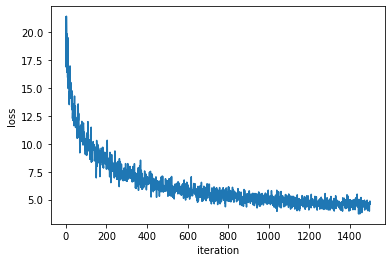

In [15]:
plt.plot(loss_hist);
plt.ylabel('loss');
plt.xlabel('iteration');

### Accuracy?
If the SVM is implemented correctly, you shuold get an training/validation accuracy around 34%-35%.

In [16]:
pred_svm = svm.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(pred_svm, y_train)))
pred_svm = svm.predict(X_val)
print('The validation accuracy is given by : %f' % (get_acc(pred_svm, y_val)))

The training accuracy is given by : 37.763265
The validation accuracy is given by : 36.900000


## Section 1.2. Improve your SVM [5 pts]
Now, try to improve the accuracy of your classifier. You can perform hyperparameter search with cross-validation, or conduct some extra preprocessing on the data. **Note that you should never use the `X_test` and `y_test` for tuning your model.**

In [17]:
# How can you improve it? 
#I created a cross validation code for the regularization paramater as shown below (code commented out for long run time) 

#k = 10 #number of cross-validation folds
#seq = np.arange(0,10000,100)
#cv_loss = []
#load = float(0)
#for r in seq:
#loss_run = []
#for j in range(k):
#    load = load+1
#    SVMr = SVM(10, 3073)
#    n1 = np.arange((j*len(X_train)/k),((j+1)*len(X_train)/k)).astype('int32')
#    n2 = np.arange(0,X_train.shape[1])
#    SVMr.train(np.delete(X_train,np.ix_(n1),0), np.delete(y_train,np.ix_(n1),0),lr=1e-7, reg_const=r, n_iters=100, batch_size=200, suppress=True)               
#    cv_loss.append(np.mean(SVMr.predict(X_train[np.ix_(n1,n2)])==y_train[np.ix_(n1,)]))
#    print(str(load/(k*len(seq))*100) + '%')
#optimal_r_index = cv_loss.index(max(cv_loss))
#optimal_r = seq[optimal_r_index]
#print(optimal_r)

#running this code gives an optimum regularization parameter of 8.3e3; running the previous SVM 
#using a regularization parameter of 8.3e3, yields the following accuracy:

svm = SVM(num_classes, num_features) #I switched this because my code is adjusted to our class notation so W is 10x3073
loss_hist = svm.train(X_train, y_train, lr=1e-7, reg_const=8.3e3, n_iters=1500, batch_size = 200)
pred_svm = svm.predict(X_val)
print('The validation accuracy is given by : %f' % (get_acc(pred_svm, y_val)))

Iter 100/1500 - loss: 9.767418242951068 
Iter 200/1500 - loss: 8.291787159762372 
Iter 300/1500 - loss: 6.942204334313379 
Iter 400/1500 - loss: 6.213008976523375 
Iter 500/1500 - loss: 5.608795743209733 
Iter 600/1500 - loss: 5.0135542395810235 
Iter 700/1500 - loss: 4.4523080176719665 
Iter 800/1500 - loss: 5.110877017349004 
Iter 900/1500 - loss: 4.375117345188908 
Iter 1000/1500 - loss: 4.089596681602379 
Iter 1100/1500 - loss: 4.570250213709945 
Iter 1200/1500 - loss: 4.399866453459199 
Iter 1300/1500 - loss: 4.457512922989771 
Iter 1400/1500 - loss: 4.467377306819339 
Iter 1500/1500 - loss: 4.597839760900448 
The validation accuracy is given by : 39.200000


### Test SVM
Evaluate the testing accuracy of your SVM:

In [18]:
pred_svm = svm.predict(X_test)
print('The testing accuracy is given by : %f' % (get_acc(pred_svm, y_test)))

The testing accuracy is given by : 37.700000


### Visualization
Visualize the weights of your best model. 

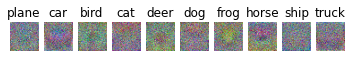

In [19]:
# Visualize the learned weights for each class.
# Hint: reshape your weights (w/o bias) to (32, 32, 3, 10), then use min-max normalization and rescale them back to 0-255.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
v_weights = np.delete(svm.w,svm.w.shape[1]-1,1).T
v_weights = np.reshape(v_weights, (32,32,3,10))
min_vweights, max_vweights = np.min(v_weights), np.max(v_weights)
# plot for each class
for y, cls in enumerate(classes):
    wplt = 255.0 * (v_weights[:,:,:,y] - min_vweights)/(max_vweights- min_vweights)
    plt_idx = y + 1
    plt.subplot(1, num_classes, plt_idx)
    plt.imshow(wplt.astype('uint8'))
    plt.axis('off')
    plt.title(cls)
plt.show()

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way that they do.

Your comments: They don't look like anything with a clear pattern because they are just weights, numbers that minimize a loss function, we shouldn't expect them to look like a horse or a ship (unless all horse and ship pictures are exactly the same in every pixel). We do note, however, that the weights will look different for each class but similar across an individual class. Also, the fact that there is no clear pattern indicates that a non-linear classifier is probably best for this kind of data.

# Section 2. Softmax Classifier (with SGD) [30 pts]

Next, you will train a Softmax classifier. This classifier consists of a linear function of the input data followed by a softmax function which outputs a vector of dimension C (number of classes) for each data point. Each entry of the softmax output vector corresponds to a confidence in one of the C classes, and like a probability distribution, the entries of the output vector sum to 1. 

## Section 2.1. Implement the Softmax Classifier [25 pts]
Recall that, from the lecture, we can write down the loss function as:
\begin{align}
\begin{gathered}
s=f(x_i, W) \\
L_i = -\log\left({\frac{e^{s_{y_i}}} {\sum_j e^{s_j}} }\right)
\end{gathered}
\end{align}

And, through some calculations, we can obtain the expression for the gradient:
\begin{align}
\nabla_{w_{l}} L_i = \left(\frac{e^{w_l^Tx_i}} {\sum_j e^{w_j^Tx_i}} - \mathbb{1}\left(y_i=l\right)\right) x_i\\
\end{align}


The softmax classifier also has 3 hyperparameters that you can experiment with :
- `lr` - the learning rate of your model. This parameter scales by how much the weights are changed according to the calculated gradient update
- `n_iter` - the number of training batches you are gonna use for updating your model.
- `reg_const` - Hyperparameter to determine the strength of regularization. In this case it is a coefficient on the term which maximizes the margin.

Same as the previous section, we provide a template for you to implement your classifier:

In [20]:
 class Softmax_Classfier():
    def __init__(self, input_size, output_size):
        """
        Initialises Softmax classifier with initializing 
        weights, alpha(learning rate), number of epochs
        and regularization constant.
        """
        self.input_size = input_size
        self.output_size = output_size
        self.w = np.random.randn(input_size, output_size) * 0.001
        
    def softmax(self, logits):
        ################################################################################
        # TODO:                                                                        #
        # Implement the softmax function here.                                         #
        ################################################################################
        self.logits = logits
        
        probs = np.zeros((self.logits.shape))                       
        for i in range(self.logits.shape[0]):
            for j in range(self.logits.shape[1]):
                probs[i,j] = (np.exp(logits[i,j])/(np.sum(np.exp(logits[:,j])))) 
        self.probs = probs
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        return probs
    
    def calc_grad_and_loss(self, X_train, y_train, reg):
        """
          Calculate gradient of the softmax loss.
          
          Inputs have dimension D, there are C classes, and we operate on minibatches
          of N examples.

          Inputs:
          - X_train: A numpy array of shape (N, D) containing a minibatch of data.
          - y_train: A numpy array of shape (N,) containing training labels; y[i] = c means
            that X[i] has label c, where 0 <= c < C.
          - reg: A float number Regularization strength;

          Returns:
          - gradient with respect to weights w; an array of same shape as w;
          - multi-class SVM loss;
         """ 
        ################################################################################
        # TODO:                                                                        #
        # Calculate the loss and gradient for the Softmax classifier.                      #
        ################################################################################
        self.training_X = X_train
        self.training_y = y_train
        self.reg = reg

        W = self.w                                                               #renaming the weight matrix because I started out callling it W and didn't want to rewrite code
        Xprime = self.training_X.T                                               #I'm following the notation uused in the lecture so I had to transpose data to get score column vectors not row vectors
        scores = self.w.dot(Xprime)                                                #Computing scores for all images at once using matrix multiplication 
        loss_by_image = np.zeros(self.training_y.shape[0])                       #Creating a vector to hold L_i, individual image loss
        for i in range(self.training_y.shape[0]):       
            loss_by_image[i] = -np.log((np.exp(scores[self.training_y[i],i])/(np.sum(np.exp(scores[:,i])))))             #compute individual image loss    
        loss_by_class = np.zeros(W.shape[0])                                     #Creating a vector to hold loss by class
        for i in range(W.shape[0]):
            loss_by_class[i] = sum(loss_by_image*(self.training_y==i))           #Computing loss by class as sum of image loss for all images that match class labels
        overall_loss = sum(loss_by_image)/self.training_y.shape[0]               #Computing multiclass SVM loss as average of individual image loss
        loss = overall_loss                                                      #Renaming loss to match following portions of code

        #Full analytical gradient
        W_grad = np.zeros((W.shape[0],W.shape[1]))                               #Creating matrix of zeros to hold gradient
        for i in range(self.training_X.shape[0]):
            addtl_grad = np.zeros((W.shape[0],W.shape[1]))                       #Creating matrix of zeros to hold gradient for each individual image
            for j in range(W.shape[0]):                                          #If statement to reflect different gradient value at true label
                addtl_grad[j] = ((np.exp(scores[j,i]-np.max(scores[:,i]))/np.sum(np.exp(scores[:,i]-np.max(scores[:,i]))))-1*(j==self.training_y[i]))*self.training_X[i,:]     #Gradient value at true label
            W_grad += addtl_grad                                                 #Adding up gradients from each image to obtain overall gradient
        W_grad = W_grad/(self.training_X.shape[0])                               #Dividing by number of images to obtain "Average gradient"                                                           
        
        #Full gradient with regularization
        grad_w = W_grad+2*reg*W
        self.grad = grad_w
        self.logits = scores
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        return grad_w, loss
        
    def train(self, X_train, y_train, lr=0.01, reg_const=0.05, 
              n_iters=1500, batch_size=200):
        """
        Train softmax classifier by taking one Stochastic Gradient Descent update
        on the input minibatch.

        Inputs:
        - X_train: A numpy array of shape (N, D) containing training data;
        N examples with D dimensions
        - y_train: A numpy array of shape (N,) containing training labels;
        - lr: A float number learning rate;
        - reg_const: A float number Regularization strength;
        - n_iters: An integer number indicating the number of training iteration;
        - batch_size: An integer indicating the number of samples per batch;
        Returns:
        - loss: Loss for this particular input batch.
        """
        loss_hist = []

        for i in range(n_iters):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            grad, loss = self.calc_grad_and_loss(X_batch, y_batch, reg_const)
            self.w -= lr * grad
            if (i + 1) % 100 == 0:
                print(f'Iter {i+1}/{n_iters} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist

    def predict(self, X_test):
        """
        Use the trained weights of svm classifier to predict labels for
        data points.

        Inputs:
        - X_test: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - pred: Predicted labels for the data in X_test. pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        ################################################################################
        # TODO:                                                                        #
        # Make a prediction based on your classifier weights                           #
        ################################################################################
        self.X_test = X_test
        
        final_logits=self.w.dot(X_test.T)
        pred = np.empty(self.X_test.shape[0], dtype=object)
        probs = self.softmax(final_logits)
        for i in range(self.X_test.shape[0]):
            pred[i] = np.where(probs[:,i]==np.amax(probs[:,i]))[0][0]   #produces predicted numbers
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        return pred


In [21]:
n_iters = 1500
batch_size = 200
num_classes = np.max(y_train) + 1
num_features = X_train.shape[1]
softmax_classifier = Softmax_Classfier(num_classes, num_features) #switched to match class notation
loss_hist = softmax_classifier.train(X_train, y_train, lr=1e-7, reg_const=2e3, n_iters=1500, batch_size=batch_size)


Iter 100/1500 - loss: 4.029738568081868 
Iter 200/1500 - loss: 3.2636622054971913 
Iter 300/1500 - loss: 3.1309429656692744 
Iter 400/1500 - loss: 3.0425398906494756 
Iter 500/1500 - loss: 2.5733176304643184 
Iter 600/1500 - loss: 2.303733284774682 
Iter 700/1500 - loss: 2.7333177708158214 
Iter 800/1500 - loss: 2.357842190019183 
Iter 900/1500 - loss: 2.2713049531226446 
Iter 1000/1500 - loss: 2.3798908968921935 
Iter 1100/1500 - loss: 2.1686633983486274 
Iter 1200/1500 - loss: 2.1423462680090783 
Iter 1300/1500 - loss: 2.2693829312591776 
Iter 1400/1500 - loss: 2.1959599864538975 
Iter 1500/1500 - loss: 2.166037115165475 


Again, plot the loss:

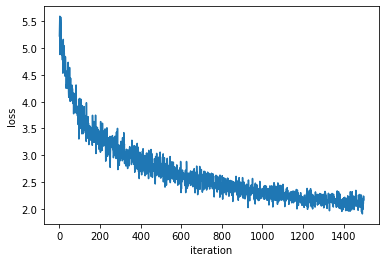

In [22]:
plt.plot(loss_hist);
plt.ylabel('loss');
plt.xlabel('iteration');

### Accuracy?
If the Softmax Classifier is implemented correctly, you shuold get an accuracy around 29%.

In [23]:
pred_softmax = softmax_classifier.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(pred_softmax, y_train)))
pred_softmax = softmax_classifier.predict(X_val)
print('The validation accuracy is given by : %f' % (get_acc(pred_softmax, y_val)))

The training accuracy is given by : 27.902041
The validation accuracy is given by : 30.600000


## Section 2.1. Improve your Softmax Classifier [5 pts]
Again, try to improve the accuracy of your classifier. You can perform hyperparameter search with cross-validation, or conduct some extra preprocessing on the data. **Note that you should never use the `X_test` and `y_test` for tuning your model.** In addition, <span style="color:red">**We expect to see an accuracy around 34% after the improvement.**</span>


In [24]:
# Get the accuracy to above 34%! 
# For hyperparameter search, you can try different combinations of (reg_const, margin, lr)

#I created a cross validation code for the regularization paramater as shown below (code commented out for long runn time)

#seq = np.arange(1000,10000,1000)
#cv_loss = []
#load = float(0)
#k=5
#for r in seq:
#loss_run = []
#for j in range(k):
#   load = load+1
#   SFMr = Softmax_Classfier(10, 3073)
#   n1 = np.arange((j*len(X_train)/k),((j+1)*len(X_train)/k)).astype('int32')
#   n2 = np.arange(0,X_train.shape[1])
#   SFMr.train(np.delete(X_train,np.ix_(n1),0), np.delete(y_train,np.ix_(n1),0),lr=1e-7, reg_const=r, n_iters=100, batch_size=200)               
#   cv_loss.append(np.mean(SFMr.predict(X_train[np.ix_(n1,n2)])==y_train[np.ix_(n1,)]))
#   print(str(load/(k*len(seq))*100) + '%')
#optimal_r_index = cv_loss.index(max(cv_loss))
#optimal_r = seq[optimal_r_index]
#print(optimal_r)

#running this code gives an optimum regularization parameter of 9e3; running the previous softmax classifier 
#using a regularization parameter of 9e3, yields the following accuracy:

softmax_classifier = Softmax_Classfier(10, 3073) #switched to match class notation
loss_hist = softmax_classifier.train(X_train, y_train, lr=1e-7, reg_const=9e3, n_iters=1500, batch_size=200)
pred_sfm = softmax_classifier.predict(X_val)
print('The validation accuracy is given by : %f' % (get_acc(pred_sfm, y_val)))

Iter 100/1500 - loss: 3.1583873812619343 
Iter 200/1500 - loss: 2.8682829344508645 
Iter 300/1500 - loss: 2.5394881390134985 
Iter 400/1500 - loss: 2.207296131882482 
Iter 500/1500 - loss: 2.1260111381079536 
Iter 600/1500 - loss: 2.180249158515432 
Iter 700/1500 - loss: 1.9485800531294222 
Iter 800/1500 - loss: 1.9558054064048636 
Iter 900/1500 - loss: 1.9298000477769 
Iter 1000/1500 - loss: 2.0108071835160715 
Iter 1100/1500 - loss: 1.9901974653884835 
Iter 1200/1500 - loss: 1.9670280005608378 
Iter 1300/1500 - loss: 1.975272387538526 
Iter 1400/1500 - loss: 1.9057229243145815 
Iter 1500/1500 - loss: 1.8946867886877052 
The validation accuracy is given by : 36.600000


### Testing Softmax

Finally, evaluate the testing accuracy.

In [25]:
pred_softmax = softmax_classifier.predict(X_test)
print('The testing accuracy is given by : %f' % (get_acc(pred_softmax, y_test)))

The testing accuracy is given by : 35.100000


### Visualization
Visualize the weights of your best model. 

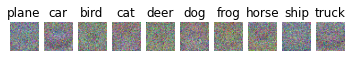

In [26]:
# Visualize the learned weights for each class.
# Hint: reshape your weights (no bias) to (32, 32, 3, 10), and then rescale them back to 0-255 using min-max normalization.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
v_weights = np.delete(softmax_classifier.w,softmax_classifier.w.shape[1]-1,1).T
v_weights = np.reshape(v_weights, (32,32,3,10))
min_vweights, max_vweights = np.min(v_weights), np.max(v_weights)

# plot for each class
for y, cls in enumerate(classes):
    wplt = 255.0 * (v_weights[:,:,:,y] - min_vweights)/(max_vweights- min_vweights)
    plt_idx = y + 1
    plt.subplot(1, num_classes, plt_idx)
    plt.imshow(wplt.astype('uint8'))
    plt.axis('off')
    plt.title(cls)
plt.show()

Describe what your visualized weights look like compared to SVM weights.

Your comments: Compared to the SVM weights, the Softmax weights are somewhat similar which indicates the similarity between the two classification methods

# Section 3. Multilayer Perceptron (MLP)
In this section, we present you a modified version of simple neural network from Professor Vicente Ordonez at the University of Virginia. You job is to read through the implementation (optional, but highly recommended), and try the MLP classifier. For additional resources on understanding forward and backpropagation, you can check the materials here: http://cs231n.github.io/optimization-2/

Consider a single-layer supervised neural network that has 4 inputs and 3 outputs. First, let's review the skeleton of a single linear layer neural network. The inputs of the network are the variables $x_1, x_2, x_3, x_4$, or the input vector $\mathbf{x}=[x_1, x_2, x_3, x_4]$, the outputs of the network are $\widehat{y}_1,\widehat{y}_2,\widehat{y}_3$, or the output vector $\widehat{\mathbf{y}}=[$$\widehat{y}$$_1,\widehat{y}_2,\widehat{y}_3]$:

<img src="fig/1_layer_fig.png" width="450"/>

The given $j$-th output $\widehat{y}_j$ of this single linear layer + activation function is computed as follows:

$$\widehat{y}_j= \text{sigmoid}(w_{1j}x_1 + w_{2j}x_2 + w_{3j}x_3 + w_{4j}x_4 + b_j) = \text{sigmoid}\Big(\sum_{i=1}^{i=4}w_{ij}x_{i} + b_j\Big)$$

In matrix notation, this would be: 

\begin{equation}
\begin{bmatrix}
  \widehat{y}_{1} \\ 
  \widehat{y}_{2} \\
  \widehat{y}_{3} 
\end{bmatrix}^T=\mathbf{Sigmoid}\Bigg(
\begin{bmatrix}
  x_{1} \\
  x_{2} \\
  x_{3} \\
  x_{4}
\end{bmatrix}^T
\begin{bmatrix}
  w_{1,1} & w_{1,2} & w_{1,3}\\
  w_{2,1} & w_{3,2} & w_{2,3}\\
  w_{3,1} & w_{3,2} & w_{3,3}\\
  w_{4,1} & w_{4,2} & w_{4,3}
\end{bmatrix}
+
\begin{bmatrix}
  b_{1} \\
  b_{2} \\
  b_{3}
\end{bmatrix}^T\Bigg)
\end{equation}

or more compactly:

\begin{equation}
\widehat{\mathbf{y}}^T = \mathbf{Sigmoid}(\mathbf{x}^T \cdot \mathbf{W} + \mathbf{b}^T)
\end{equation}

The element-wise sigmoid function is: $\mathbf{Sigmoid}(\mathbf{x}) = 1 \;/\; (1 + exp(-\mathbf{x}))$, or alternatively: $\mathbf{Sigmoid}(\mathbf{x}) = exp(\mathbf{x})\;/\;(1 + exp(\mathbf{x}))$. Here the sigmoid is separated logically into an activation layer $\sigma(x)$ and a linear layer $\text{linear}(3,4)$ as illustrated in figure. 

Training these weights $\mathbf{W}$ and biases $\mathbf{b}$ requires having many training pairs $(\widehat{\mathbf{y}}^{(m)}, \mathbf{x}^{(m)})$. The inputs $\mathbf{x}$ can be the pixels of an image, indices of words, the entries in a database, and the outputs $\widehat{\mathbf{y}}$ can also be literally anything, including a number indicating a category, a set of numbers indicating the indices of words composing a sentence, an output image itself, etc.

## 3.1. Forward-propagation

Computing the outputs $\widehat{\mathbf{y}}$ from the inputs $\mathbf{x}$ in this network composed of a single linear layer, and a sigmoid layer, is called forward-propagation. Below is the code that implements these two operations:

In [27]:
import numpy as np
import numpy.matlib

class nn_Sigmoid:
    def forward(self, x):
        return 1 / (1 + np.exp(-x))

class nn_Linear:
    def __init__(self, input_dim, output_dim):
        # Initialized with random numbers from a gaussian N(0, 0.001)
        self.weight = np.matlib.randn(input_dim, output_dim) * 0.001
        self.bias = np.matlib.randn((1, output_dim)) * 0.001
        
    # y = Wx + b
    def forward(self, x):
        return np.dot(x, self.weight) + self.bias #basically computes the linear comb.
    
    def getParameters(self):
        return [self.weight, self.bias] #gives weight and bias

# Let's test the composition of the two functions (forward-propagation in the neural network).
x1 = np.array([[1, 2, 2, 3]]) #Feeding input
y_hat1 = nn_Sigmoid().forward(nn_Linear(4, 3).forward(x1)) #output is forwarding the linear combination through the activation function
print('x[1] = '+ str(x1))
print('y_hat[1] = ' + str(y_hat1) + '\n')

# Let's test the composition of the two functions (forward-propagation in the neural network).
x2 = np.array([[4, 5, 2, 1]])
y_hat2 = nn_Sigmoid().forward(nn_Linear(4, 3).forward(x2))
print('x[2] = '+ str(x2))
print('y_hat[2] = ' + str(y_hat2) + '\n')

# We can also compute both at once, which could be more efficient since it requires a single matrix multiplication.
x = np.concatenate((x1, x2), axis = 0)
y_hat = nn_Sigmoid().forward(nn_Linear(4, 3).forward(x))
print('x = ' + str(x))
print('y_hat = ' + str(y_hat))

x[1] = [[1 2 2 3]]
y_hat[1] = [[0.49754219 0.50033936 0.50028514]]

x[2] = [[4 5 2 1]]
y_hat[2] = [[0.50080779 0.50324362 0.50226695]]

x = [[1 2 2 3]
 [4 5 2 1]]
y_hat = [[0.50131101 0.49904719 0.49853213]
 [0.50215788 0.49746764 0.50078732]]


## 3.2. Loss functions.

After computing the output predictions $\widehat{\mathbf{y}}$ it is necessary to compare these against the true values of $\mathbf{y}$. Let's call these true, correct, or desired values $\mathbf{y}$. Typically, a simple loss or cost function is used to measure the degree by which the prediction $\widehat{\mathbf{y}}$ is wrong with respect to $\mathbf{y}$. A common loss function for regression is the sum of squared differences between the prediction and its true value. Assuming a prediction $\widehat{\mathbf{y}}^{(d)}$ for our training sample $\mathbf{x}^{(d)}$ with true value $\mathbf{y}^{(d)}$, then the loss can be computed as:

$$loss(\widehat{\mathbf{y}}^{(d)}, \mathbf{y}^{(d)}) = (\widehat{y}^{(d)}_1 - y^{(d)}_1)^2 + (\widehat{y}^{(d)}_2 - y^{(d)}_2)^2 + (\widehat{y}^{(d)}_3 - y^{(d)}_3)^2 = \sum_{j=1}^{j=3}(\widehat{y}^{(d)}_j - y^{(d)}_j)^2$$

The goal is to modify the parameters [$\mathbf{W}, \mathbf{b}$] in the Linear layer so that the value of $loss(\widehat{\mathbf{y}}^{(d)}, \mathbf{y}^{(d)})$ becomes as small as possible for all training samples in a set $D=\{(\mathbf{x}^{(d)},\mathbf{y}^{(d)})\}$. This would in turn ensure that predictions $\widehat{\mathbf{y}}$ are as similar as possible to the true values $\mathbf{y}$. To achieve this we need to minimize the following function:

$$\mathcal{L}(\mathbf{W}, \mathbf{b}) = \sum_{d=1}^{d=|D|} loss(\widehat{\mathbf{y}}^{(d)}, \mathbf{y}^{(d)})$$

The only two variables for our model in the function $\mathcal{L}(\mathbf{W}, \mathbf{b})$ are $\mathbf{W}$ and $\mathbf{b}$, this is because the training dataset $D$ is fixed. Finding the values of $\mathbf{W}$ and $\mathbf{b}$ that minimize the the loss, particularly for complex functions, is typically done using gradient based optimization, like Stochastic Gradient Descent (SGD). 

In [28]:
class nn_MSECriterion:  # MSE = mean squared error.
    def forward(self, predictions, labels):
        return np.sum(np.square(predictions - labels))

# Let's test the loss function.
y_hat = np.array([[0.23, 0.25, 0.33], [0.23, 0.25, 0.33], [0.23, 0.25, 0.33], [0.23, 0.25, 0.33]])
y_true = np.array([[0.25, 0.25, 0.25], [0.33, 0.33, 0.33], [0.77, 0.77, 0.77], [0.80, 0.80, 0.80]])

nn_MSECriterion().forward(y_hat, y_true)

1.6271000000000002

## 3.3. Backward-propagation (Backpropagation)

As we discussed in class, backpropagation is just applying the chain-rule in calculus to compute the derivative of a function which is the composition of many functions (this is essentially definition of the neural network). 

Below is the implementation of required derivative computations for our simple network. You are highly advised to derive the derivatives implemented here to make sure you understand how one arrives at them. 

In [29]:
# This is referred above as f(u).

class nn_MSECriterion:
    def forward(self, predictions, labels):
        return np.sum(np.square(predictions - labels))
        
    def backward(self, predictions, labels): #returns derivative (dMSE/dx)
        num_samples = labels.shape[0]
        return 2 * (predictions - labels)
    
# This is referred above as g(v).
class nn_Sigmoid:         #gets fed data, outputs activation value
    def forward(self, x):
        return 1 / (1 + np.exp(-x))
    
    def backward(self, x, gradOutput):
        # It is usually a good idea to use gv from the forward pass and not recompute it again here.
        gv = 1 / (1 + np.exp(-x)) 
        return np.multiply(np.multiply(gv, (1 - gv)), gradOutput)

# This is referred above as h(W, b)
class nn_Linear:
    def __init__(self, input_dim, output_dim):
        # Initialized with random numbers from a gaussian N(0, 0.001)
        self.weight = np.matlib.randn(input_dim, output_dim) * 0.001
        self.bias = np.matlib.randn((1, output_dim)) * 0.001
        self.gradWeight = np.zeros_like(self.weight)
        self.gradBias = np.zeros_like(self.bias)
        
    def forward(self, x):
        return np.dot(x, self.weight) + self.bias #forward feed into activation fn
    
    def backward(self, x, gradOutput):
        # dL/dw = dh/dw * dL/dv
        self.gradWeight = np.dot(x.T, gradOutput)
        # dL/db = dh/db * dL/dv
        #self.gradBias = np.copy(gradOutput)
        self.gradBias = np.copy(np.sum(gradOutput, axis=0))
        # return dL/dx = dh/dx * dL/dv
        return np.dot(gradOutput, self.weight.T)
    
    def getParameters(self):
        params = [self.weight, self.bias]
        gradParams = [self.gradWeight, self.gradBias]
        return params, gradParams
    
# Let's test some dummy inputs for a full pass of forward and backward propagation.
x1 = np.array([[1, 2, 2, 3]])
y1 = np.array([[0.25, 0.25, 0.25]])

# Define the operations.
linear = nn_Linear(4, 3)  # h(W, b)
sigmoid = nn_Sigmoid()  # g(v)
loss = nn_MSECriterion()  # f(u)

# Forward-propagation.
lin = linear.forward(x1)  #creates linear combination to feed forward
y_hat = sigmoid.forward(lin) #takes lin and passes it through activation fn to get activation value
loss_val = loss.forward(y_hat, y1) # Loss function. #computes MSE

# Backward-propagation.
dy_hat = loss.backward(y_hat, y1) #derivative of MSE
dlin = sigmoid.backward(lin, dy_hat) #derivative of sigmoid X derivative of MSE
dx1 = linear.backward(x1, dlin) #final step of BWP, 3 derivatives multiplied 

print('\n num_samples = ' + str(y1.shape[0]))

# Show parameters of the linear layer.
print('\nW = ' + str(linear.weight))
print('B = ' + str(linear.bias))

# Show the intermediate outputs in the forward pass.
print('\nx1    = '+ str(x1))
print('lin   = ' + str(lin))
print('y_hat = ' + str(y_hat))

print('\nloss = ' + str(loss_val))

# Show the intermediate gradients with respect to inputs in the backward pass.
print('\ndy_hat = ' + str(dy_hat))
print('dlin   = ' + str(dlin))
print('dx1    = ' + str(dx1))

# Show the gradients with respect to parameters.
print('\ndW = ' + str(linear.gradWeight))
print('dB = ' + str(linear.gradBias))


 num_samples = 1

W = [[ 6.41594579e-04 -4.07191972e-04 -1.46335336e-03]
 [ 7.74586079e-04  5.06655771e-04 -4.00826284e-05]
 [-1.11747957e-03  7.41360968e-04 -7.16546408e-04]
 [-8.77144987e-04 -9.64589018e-05  1.58516189e-03]]
B = [[ 0.00036203  0.00160836 -0.0002544 ]]

x1    = [[1 2 2 3]]
lin   = [[-0.0023136   0.00340782  0.00152448]]
y_hat = [[0.4994216  0.50085195 0.50038112]]

loss = 0.18782854315638775

dy_hat = [[0.4988432  0.50170391 0.50076224]]
dlin   = [[0.12471063 0.12542561 0.12519049]]
dx1    = [[-1.54256556e-04  1.55128768e-04 -1.36080724e-04  7.69594650e-05]]

dW = [[0.12471063 0.12542561 0.12519049]
 [0.24942127 0.25085123 0.25038097]
 [0.24942127 0.25085123 0.25038097]
 [0.3741319  0.37627684 0.37557146]]
dB = [[0.12471063 0.12542561 0.12519049]]


## 3.4. Gradient checking 

The gradients can also be computed with numerical approximation using the definition of derivatives. Let a single input pair $(\mathbf{x}, \mathbf{y})$ be the input, for each entry $w_{ij}$ in the weight matrix $\mathbf{W}$, the partial derivatives can be computed as follows:

$$\frac{\partial \mathcal{L}(\mathbf{W},\mathbf{b})}{\partial w_{ij}} = \frac{\mathcal{L}(\mathbf{W} + \mathbf{E}_{ij},b) - \mathcal{L}(\mathbf{W} - \mathbf{E}_{ij}, b)}{2\epsilon}, $$

where $\mathbf{E}_{ij}$ is a matrix that has $\epsilon$ in its $(i,j)$ entry and zeros everywhere else. Intuitively this gradient tells how would the value of the loss changes if we change a particular weight $w_{ij}$ by an $\epsilon$ amount. We can do the same to compute derivatives with respect to the bias parameters $b_i$. Below is the code that checks for a given input $(\mathbf{x}, \mathbf{y})$, the gradients for the matrix $\mathbf{W}$. 

In [30]:
# We will compute derivatives with respect to a single data pair (x,y)
x = np.array([[2.34, 3.8, 34.44, 5.33]])
y = np.array([[3.2, 4.2, 5.3]])

# Define the operations.
linear = nn_Linear(4, 3)
sigmoid = nn_Sigmoid()
criterion = nn_MSECriterion()

# Forward-propagation.
a0 = linear.forward(x)
a1 = sigmoid.forward(a0)
loss = criterion.forward(a1, y) # Loss function.

# Backward-propagation.
da1 = criterion.backward(a1, y)
da0 = sigmoid.backward(a0, da1)
dx = linear.backward(x, da0)

gradWeight = linear.gradWeight
gradBias = linear.gradBias

approxGradWeight = np.zeros_like(linear.weight)
approxGradBias = np.zeros_like(linear.bias)

# We will verify here that gradWeights are correct and leave it as an excercise
# to verify the gradBias.
epsilon = 0.0001
for i in range(0, linear.weight.shape[0]):
    for j in range(0, linear.weight.shape[1]):
        # Compute f(w)
        fw = criterion.forward(sigmoid.forward(linear.forward(x)), y) # Loss function.
        # Compute f(w + eps)
        shifted_weight = np.copy(linear.weight)
        shifted_weight[i, j] = shifted_weight[i, j] + epsilon
        shifted_linear = nn_Linear(4, 3)
        shifted_linear.bias = linear.bias
        shifted_linear.weight = shifted_weight
        fw_epsilon = criterion.forward(sigmoid.forward(shifted_linear.forward(x)), y) # Loss function
        # Compute (f(w + eps) - f(w)) / eps
        approxGradWeight[i, j] = (fw_epsilon - fw) / epsilon

# These two outputs should be similar up to some precision.
print('gradWeight: ' + str(gradWeight))
print('\napproxGradWeight: ' + str(approxGradWeight))

gradWeight: [[ -3.14694207  -4.33443284  -5.60020597]
 [ -5.11041875  -7.03882257  -9.09435158]
 [-46.31653205 -63.79396033 -82.42354434]
 [ -7.16803472  -9.87287481 -12.75602472]]

approxGradWeight: [[ -3.14690097  -4.3344037   -5.60015718]
 [ -5.11031032  -7.03874567  -9.09422286]
 [-46.30758535 -63.78758747 -82.41289902]
 [ -7.16782135  -9.87272346 -12.75577138]]


## Section 3.4. Playing with the Simple NN [30 pts]
Now, we provide a simple NN model that has an training accuracy around 46%. You job here is to first run and check the simple NN model, and the experiments it with:
- Try using 3 different numbers of layers for the simple NN, and plot the accuracy as a function of the number of layers. 
- Try 4 different numbers of hidden state size, and plot the accuracy as a function of the number you have tried.
- Try different activation function (Sigmoid, ReLU)
- Briefly describe what you've observed in the above experiments

Note that you are free to create your own Simple_NN class for your experiments.

In [31]:
class nn_CECriterionWithLogits:
    def forward(self, logits, labels):
        y_indices = np.arange(len(labels))
        self.probs = softmax(logits)
        correct_class_prob = self.probs[y_indices, labels].reshape(-1, 1)
        loss = np.sum(-np.log(correct_class_prob)) / len(correct_class_prob)
        return loss
    
    def backward(self, labels):
        y_indices = np.arange(len(labels))
        gradOutput = self.probs
        gradOutput[y_indices, labels] -= 1
        return gradOutput / len(labels)
    
class nn_ReLU:
    def forward(self, x):
        # Forward pass.
        return np.maximum(0, x)
    
    def backward(self, x, gradOutput):
        # Backward pass
        return np.where(x < 0, 0, np.multiply(1, gradOutput))
    
def softmax(x):
    exp = np.exp(x - x.max()) # stability trick
    return (exp / np.sum(exp, axis=1))

In [32]:
class Simple_NN(object):
    def __init__(self, input_size, output_size, hidden_state_size=64):
        self.linear1 = nn_Linear(input_size, hidden_state_size)
        self.activation = nn_ReLU()
        self.linear2 = nn_Linear(hidden_state_size, output_size)
        
    def forward(self, X):
        self.X = X
        self.x1 = self.linear1.forward(self.X)
        self.a1 = self.activation.forward(self.x1)
        logits = self.linear2.forward(self.a1)
        return logits
    
    def backward(self, gradOutput):
        dx2 = self.linear2.backward(self.a1, gradOutput)
        da1 = self.activation.backward(self.x1, dx2)
        self.linear1.backward(self.X, da1)
    
    def update(self, lr):
        self.linear1.weight = self.linear1.weight - lr * (self.linear1.gradWeight)
        self.linear1.bias = self.linear1.bias - lr * (self.linear1.gradBias)
        self.linear2.weight = self.linear2.weight - lr * (self.linear2.gradWeight)
        self.linear2.bias = self.linear2.bias - lr * (self.linear2.gradBias)
        
    def train(self, X_train, y_train, loss_criterion=nn_CECriterionWithLogits(), 
              lr=1e-5, n_iter=1500, batch_size=200):
        loss_hist = []

        for i in range(n_iter):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            
            logits = self.forward(X_batch)
            loss = loss_criterion.forward(logits, y_batch)
            loss_grad = loss_criterion.backward(y_batch)
            self.backward(loss_grad)
            self.update(lr)

            if (i + 1) % 100 == 0:
                print(f'Iter {i+1}/{n_iter} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist
    def predict(self, X):
        return np.asarray(np.argmax(softmax(self.forward(X)), axis=1)).squeeze(1)

As the bias is explicitly handled in the MLP code, stripped off the ones we have concatenated to the feature vectors.

In [33]:
X_train = X_train[:, :3072]
X_val = X_val[:, :3072]
X_test = X_test[:, :3072]

Now, run the simple NN to check the accuracy:

In [34]:
model = Simple_NN(X_train.shape[1], np.max(y_train)+1, hidden_state_size=64)
n_iter = 1500
batch_size = 200
loss_hist = model.train(X_train, y_train, lr=1e-4)

Iter 100/1500 - loss: 2.2602060808246125 
Iter 200/1500 - loss: 2.1505986679408218 
Iter 300/1500 - loss: 2.0370292515102846 
Iter 400/1500 - loss: 1.9872312460786354 
Iter 500/1500 - loss: 1.9275780595769176 
Iter 600/1500 - loss: 1.9349334283740018 
Iter 700/1500 - loss: 1.9017132785529618 
Iter 800/1500 - loss: 1.849450082295823 
Iter 900/1500 - loss: 1.8490679051222616 
Iter 1000/1500 - loss: 1.7980953713993963 
Iter 1100/1500 - loss: 1.750550194807669 
Iter 1200/1500 - loss: 1.7876602147477325 
Iter 1300/1500 - loss: 1.7876297797319267 
Iter 1400/1500 - loss: 1.6324196632033445 
Iter 1500/1500 - loss: 1.8144128483042345 


The training accuracy is given by : 39.844898
The training accuracy is given by : 40.100000


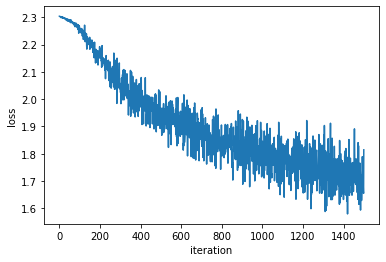

In [35]:
plt.plot(loss_hist);
plt.ylabel('loss');
plt.xlabel('iteration');
predict = model.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(predict, y_train)))
predict = model.predict(X_val)
print('The training accuracy is given by : %f' % (get_acc(predict, y_val)))

### Section 3.4.1. Different numbers of layers [12 pts]
Try building 3 simple NN with different numbers of layers. Plot the training/validation/test accuracy as a function of the numbers of layers.

Iter 100/1500 - loss: 1.8234838955156887 
Iter 200/1500 - loss: 1.6504777475131802 
Iter 300/1500 - loss: 1.5540634468015235 
Iter 400/1500 - loss: 1.445709623811561 
Iter 500/1500 - loss: 1.6210653535567767 
Iter 600/1500 - loss: 1.366055346338868 
Iter 700/1500 - loss: 1.4106115324697073 
Iter 800/1500 - loss: 1.4480765228268841 
Iter 900/1500 - loss: 1.2919393002525619 
Iter 1000/1500 - loss: 1.3626632052799263 
Iter 1100/1500 - loss: 1.304652326504152 
Iter 1200/1500 - loss: 1.253326829639355 
Iter 1300/1500 - loss: 1.3972507974389305 
Iter 1400/1500 - loss: 1.3160868425288834 
Iter 1500/1500 - loss: 1.3202116088549627 
Iter 100/1500 - loss: 2.302405485500892 
Iter 200/1500 - loss: 2.3022897137375207 
Iter 300/1500 - loss: 2.301876884029552 
Iter 400/1500 - loss: 2.3017572270379016 
Iter 500/1500 - loss: 2.2999695095173034 
Iter 600/1500 - loss: 2.296860825110346 
Iter 700/1500 - loss: 2.2782622007317554 
Iter 800/1500 - loss: 2.2366851066243303 
Iter 900/1500 - loss: 2.13480184701

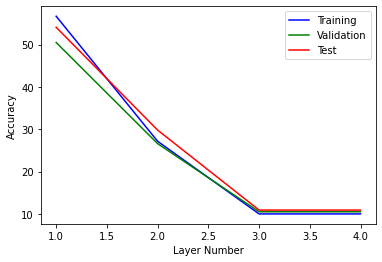

In [36]:
################## Multi-Layer Neural Network  ################################################
class MultiLayer_NN(object):
    def __init__(self, input_size, output_size, hidden_state_size=np.array([64]), layers = 1):
        self.linear = [i for i in range(layers+1)]
        self.activation = nn_ReLU()
        self.layers = layers
        for i in range(self.layers+1):
            if i==0:
                self.linear[i] = nn_Linear(input_size, hidden_state_size[i])
            elif i==(layers):
                self.linear[i] = nn_Linear(hidden_state_size[i-1], output_size)
            else:                
                self.linear[i] = nn_Linear(hidden_state_size[i-1], hidden_state_size[i])
                       
    def forward(self, X):
        self.X = X
        self.x = [i for i in range(self.layers+1)]
        self.a = [i for i in range(self.layers+1)]
        for i in range(self.layers+1):
            if i==0:
                self.x[i] = self.linear[i].forward(self.X)
                self.a[i] = self.activation.forward(self.x[i])
            elif i==(self.layers):
                logits = self.linear[i].forward(self.a[i-1])
            else:
                self.x[i] = self.linear[i].forward(self.a[i-1])
                self.a[i] = self.activation.forward(self.x[i])
        return logits
    
    def backward(self, gradOutput):
        dx = [i for i in range(self.layers+1)]
        da = [i for i in range(self.layers+1)]
        for i in reversed(range(self.layers+1)):
            if i==(self.layers):
                dx[i] = self.linear[i].backward(self.a[i-1], gradOutput)
            elif i==0:
                da[i] = self.activation.backward(self.x[i], dx[i+1])
                self.linear[i].backward(self.X, da[i])        
            else:
                da[i] = self.activation.backward(self.x[i], dx[i+1])
                dx[i] = self.linear[i].backward(self.a[i-1], da[i])
                
    def update(self, lr):
        for i in range(self.layers+1):
            if i == (self.layers):
                self.linear[i].weight = self.linear[i].weight - lr * (self.linear[i].gradWeight)
                self.linear[i].bias = self.linear[i].bias - lr * (self.linear[i].bias)
            elif i == 0:
                self.linear[i].weight = self.linear[i].weight - lr * (self.linear[i].gradWeight)
                self.linear[i].bias = self.linear[i].bias - lr * (self.linear[i].gradBias)
            else:
                self.linear[i].weight = self.linear[i].weight - lr * (self.linear[i].gradWeight)
                self.linear[i].bias = self.linear[i].bias - lr * (self.linear[i].gradBias)
        
    def train(self, X_train, y_train, loss_criterion=nn_CECriterionWithLogits(), 
              lr=1e-5, n_iters=1500, batch_size=200):
        loss_hist = []

        for i in range(n_iters):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            
            logits = self.forward(X_batch)
            loss = loss_criterion.forward(logits, y_batch)
            loss_grad = loss_criterion.backward(y_batch)
            self.backward(loss_grad)
            self.update(lr)

            if (i + 1) % 100 == 0:
                print(f'Iter {i+1}/{n_iters} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist
    def predict(self, X):
        return np.asarray(np.argmax(softmax(self.forward(X)), axis=1)).squeeze(1)
#################################################################################################################

# Type your code here
acc_hist_1 = np.zeros(4)
acc_hist_2 = np.zeros(4)
acc_hist_3 = np.zeros(4)

lrs = np.array([1,2,3,4])

for i in range(4):
    model = MultiLayer_NN(X_train.shape[1], np.max(y_train)+1, hidden_state_size=np.array([256,256,256,256]), layers=lrs[i])
    model.train(X_train, y_train, lr=1e-3, n_iters=1500)
    acc_hist_1[i] = get_acc(model.predict(X_train), y_train)
    acc_hist_2[i] = get_acc(model.predict(X_val), y_val)
    acc_hist_3[i] = get_acc(model.predict(X_test), y_test)

    
fig=plt.figure()
ax=fig.add_subplot(111)
 
ax.plot(lrs,acc_hist_1,c='b',ls='-',label='Training')
ax.plot(lrs,acc_hist_2,c='g',ls='-',label='Validation')
ax.plot(lrs,acc_hist_3,c='r',ls='-',label='Test')
plt.ylabel('Accuracy');
plt.xlabel('Layer Number'); 
plt.legend(loc=1)
plt.show()

### Section 3.4.2. Different numbers of hidden state size [7 pts]
Try 4 different numbers of hidden state size, and plot the accuracy as a function of the number you have tried. We recommend you to test numbers like 8, 16, 32, 64, 128, 256. Plot the training/validation/test accuracy as a function of the hidden state size your picked.

Iter 100/1500 - loss: 2.2976027612304444 
Iter 200/1500 - loss: 2.2419902474955173 
Iter 300/1500 - loss: 2.1626335717338394 
Iter 400/1500 - loss: 2.056798763725183 
Iter 500/1500 - loss: 2.0559873483270947 
Iter 600/1500 - loss: 2.0063305380958543 
Iter 700/1500 - loss: 1.9559697961586437 
Iter 800/1500 - loss: 1.925174892144772 
Iter 900/1500 - loss: 1.8971480490021195 
Iter 1000/1500 - loss: 1.7855538892391771 
Iter 1100/1500 - loss: 1.780018787460026 
Iter 1200/1500 - loss: 1.88008082810171 
Iter 1300/1500 - loss: 1.817168308322182 
Iter 1400/1500 - loss: 1.8168936572651322 
Iter 1500/1500 - loss: 1.7746163229297094 
Iter 100/1500 - loss: 2.283485356229788 
Iter 200/1500 - loss: 2.2146167492217685 
Iter 300/1500 - loss: 2.1277012475340147 
Iter 400/1500 - loss: 2.0073201662766524 
Iter 500/1500 - loss: 2.067865575646385 
Iter 600/1500 - loss: 1.9557110185749031 
Iter 700/1500 - loss: 1.9105661187060128 
Iter 800/1500 - loss: 1.916177899848101 
Iter 900/1500 - loss: 1.8952393597004

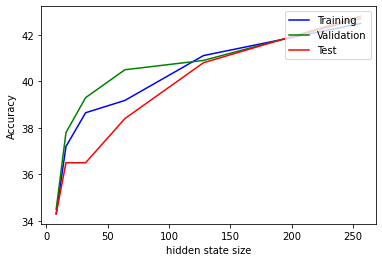

In [37]:
# Type your code here
acc_hist_1 = np.zeros(6)
acc_hist_2 = np.zeros(6)
acc_hist_3 = np.zeros(6)

hs = np.array([8,16,32,64,128,256])

for i in range(6):
    model = Simple_NN(X_train.shape[1], np.max(y_train)+1, hidden_state_size=hs[i])
    model.train(X_train, y_train, lr=1e-4, n_iter=1500)
    acc_hist_1[i] = get_acc(model.predict(X_train), y_train)
    acc_hist_2[i] = get_acc(model.predict(X_val), y_val)
    acc_hist_3[i] = get_acc(model.predict(X_test), y_test)

fig=plt.figure()
ax=fig.add_subplot(111)
 
ax.plot(hs,acc_hist_1,c='b',ls='-',label='Training')
ax.plot(hs,acc_hist_2,c='g',ls='-',label='Validation')
ax.plot(hs,acc_hist_3,c='r',ls='-',label='Test')
plt.ylabel('Accuracy');
plt.xlabel('hidden state size'); 
plt.legend(loc=1)
plt.show()

### Section 3.4.3. Different activation functions [7 pts]
Try both ReLU and Sigmoid activation, and report the training/validation/test accuracy.

In [38]:
# Type your code here

#Sigmoid
###############################################################################################################
class Sigmoid_NN(object):
    def __init__(self, input_size, output_size, hidden_state_size=64):
        self.linear1 = nn_Linear(input_size, hidden_state_size)
        self.activation = nn_Sigmoid()
        self.linear2 = nn_Linear(hidden_state_size, output_size)
        
    def forward(self, X):
        self.X = X
        self.x1 = self.linear1.forward(self.X)
        self.a1 = self.activation.forward(self.x1)
        logits = self.linear2.forward(self.a1)
        return logits
    
    def backward(self, gradOutput):
        dx2 = self.linear2.backward(self.a1, gradOutput)
        da1 = self.activation.backward(self.x1, dx2)
        self.linear1.backward(self.X, da1)
    
    def update(self, lr):
        self.linear1.weight = self.linear1.weight - lr * (self.linear1.gradWeight)
        self.linear1.bias = self.linear1.bias - lr * (self.linear1.gradBias)
        self.linear2.weight = self.linear2.weight - lr * (self.linear2.gradWeight)
        self.linear2.bias = self.linear2.bias - lr * (self.linear2.bias)
        
    def train(self, X_train, y_train, loss_criterion=nn_CECriterionWithLogits(), 
              lr=1e-5, n_iters=1500, batch_size=200):
        loss_hist = []

        for i in range(n_iters):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            
            logits = self.forward(X_batch)
            loss = loss_criterion.forward(logits, y_batch)
            loss_grad = loss_criterion.backward(y_batch)
            self.backward(loss_grad)
            self.update(lr)

            if (i + 1) % 100 == 0:
                print(f'Iter {i+1}/{n_iters} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist
    def predict(self, X):
        return np.asarray(np.argmax(softmax(self.forward(X)), axis=1)).squeeze(1)
sigmoid = Sigmoid_NN(X_train.shape[1], np.max(y_train)+1, hidden_state_size=64)
batch_size = 200
sigmoid.train(X_train, y_train, lr=1e-4, n_iters = 1500)
predict = sigmoid.predict(X_train)
print('The Sigmoid training accuracy is given by : %f' % (get_acc(predict, y_train)))
predict = sigmoid.predict(X_val)
print('The Sigmoid validation accuracy is given by : %f' % (get_acc(predict, y_val)))
predict = sigmoid.predict(X_test)
print('The Sigmoid validation accuracy is given by : %f' % (get_acc(predict, y_test)))
##############################################################################################################

#ReLU: We had already constructed a simple neural network using RelU earlier, repeating the process here
##############################################################################################################
class ReLU_NN(object):
    def __init__(self, input_size, output_size, hidden_state_size=64):
        self.linear1 = nn_Linear(input_size, hidden_state_size)
        self.activation = nn_ReLU()
        self.linear2 = nn_Linear(hidden_state_size, output_size)
        
    def forward(self, X):
        self.X = X
        self.x1 = self.linear1.forward(self.X)
        self.a1 = self.activation.forward(self.x1)
        logits = self.linear2.forward(self.a1)
        return logits
    
    def backward(self, gradOutput):
        dx2 = self.linear2.backward(self.a1, gradOutput)
        da1 = self.activation.backward(self.x1, dx2)
        self.linear1.backward(self.X, da1)
    
    def update(self, lr):
        self.linear1.weight = self.linear1.weight - lr * (self.linear1.gradWeight)
        self.linear1.bias = self.linear1.bias - lr * (self.linear1.gradBias)
        self.linear2.weight = self.linear2.weight - lr * (self.linear2.gradWeight)
        self.linear2.bias = self.linear2.bias - lr * (self.linear2.bias)
        
    def train(self, X_train, y_train, loss_criterion=nn_CECriterionWithLogits(), 
              lr=1e-5, n_iters=1500, batch_size=200):
        loss_hist = []

        for i in range(n_iters):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            
            logits = self.forward(X_batch)
            loss = loss_criterion.forward(logits, y_batch)
            loss_grad = loss_criterion.backward(y_batch)
            self.backward(loss_grad)
            self.update(lr)

            if (i + 1) % 100 == 0:
                print(f'Iter {i+1}/{n_iters} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist
    def predict(self, X):
        return np.asarray(np.argmax(softmax(self.forward(X)), axis=1)).squeeze(1)
relu = ReLU_NN(X_train.shape[1], np.max(y_train)+1, hidden_state_size=64)
batch_size = 200
relu.train(X_train, y_train, lr=1e-4, n_iters = 1500)
predict = relu.predict(X_train)
print('The ReLU training accuracy is given by : %f' % (get_acc(predict, y_train)))
predict = relu.predict(X_val)
print('The ReLU validation accuracy is given by : %f' % (get_acc(predict, y_val)))
predict = relu.predict(X_test)
print('The ReLU validation accuracy is given by : %f' % (get_acc(predict, y_test)))
#########################################################################################################

Iter 100/1500 - loss: 2.3014898515056617 
Iter 200/1500 - loss: 2.300298223647679 
Iter 300/1500 - loss: 2.3000604983937523 
Iter 400/1500 - loss: 2.297348188655657 
Iter 500/1500 - loss: 2.298273646024317 
Iter 600/1500 - loss: 2.2949071990607033 
Iter 700/1500 - loss: 2.294188663147824 
Iter 800/1500 - loss: 2.290046773932314 
Iter 900/1500 - loss: 2.2889772892226667 
Iter 1000/1500 - loss: 2.2866702436632367 
Iter 1100/1500 - loss: 2.28432575020267 
Iter 1200/1500 - loss: 2.2811931626449367 
Iter 1300/1500 - loss: 2.2770796583412922 
Iter 1400/1500 - loss: 2.270956594903807 
Iter 1500/1500 - loss: 2.269325022646836 
The Sigmoid training accuracy is given by : 23.297959
The Sigmoid validation accuracy is given by : 24.000000
The Sigmoid validation accuracy is given by : 24.900000
Iter 100/1500 - loss: 2.2498148116410954 
Iter 200/1500 - loss: 2.202561391766254 
Iter 300/1500 - loss: 2.0485987682322646 
Iter 400/1500 - loss: 1.9603917106541604 
Iter 500/1500 - loss: 1.9356232756299925

### Section 3.4.4. What did you see? [4 pts]
Desribe what you see in the experiments above in 5-6 sentences.

Your answer:

We observe that increasing the number of hidden layers for this task leads to a sharp reduction in accuracy; the graph shows that one hidden layer is the optimal number of hidden layers (among numbers greater than zero). I couldn't get the neural network learning anything for more than 2 layers using multiple settings for hyperparameters.

The different hidden layer size shows that around 64 to 128 is the "elbow" of the accuracy graph and increasing the size of layers beyond that doesn't offer a strong benefit to the validation and test accuracy.

The Sigmoid activation function produces less accuracy than the ReLU for the same batch size, learning rate, and number of iterations. The Sigmoid can get better if we increase the number of iterations (15000 iterations leads to about 30% accuracy - a 10% increase), which reflects the fact the Sigmoid is a slow learner. But all else held constant, ReLU is much better.